In [523]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from create_structures import create_structures
from load_structures import load_structures
from read_spectrum_curve import read_spectrum_curve
from sklearn.preprocessing import normalize

In [8]:
def gauss_function(x, a=1, b=100, c=10):
    return a * np.exp(-(b - x) ** 2 / 2 / c ** 2)

In [9]:
def taylor_series_for_gf(x, a=1, b=100, c=10):
    return a - a * (x - b) ** 2 / 2 / c ** 2  + a * (x - b) ** 4 / 8 / c ** 4

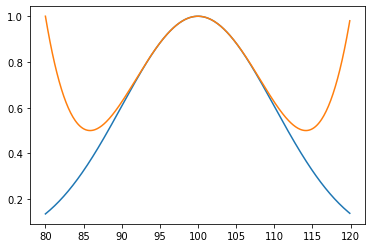

In [15]:
x = np.arange(80, 120, 0.1)
gf = gauss_function(x)

ts = taylor_series_for_gf(x)
plt.plot(x, gf)
plt.plot(x, ts)

In [519]:
struct_name = 'acetic_acid'
create_structures([struct_name])
structs = load_structures([struct_name])


New structures have been successfully created!
Structure(s) acetic_acid have been successfully loaded!


In [520]:
data = structs[struct_name].veda_matrix[:]
data['ped_sum'] = structs[struct_name].veda_matrix.drop('freq', axis=1).sum()

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


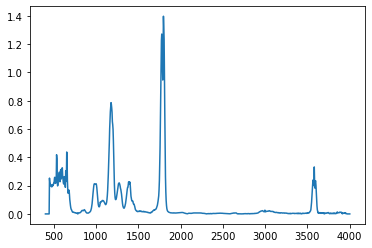

In [522]:
spectrum = read_spectrum_curve(struct_name + '.CSV', norm=False)
plt.plot(spectrum.x, spectrum.y)

In [439]:
indxs = argrelextrema(spectrum.y.values, np.greater, order=10)
indxs

(array([ 193,  215,  270,  284,  297,  380,  393,  458,  470,  484,  531,
         551,  661,  674,  726,  740,  763,  776,  821,  842,  866,  883,
         925,  951, 1016, 1033, 1123, 1202, 1220, 1268, 1281, 1313, 1348,
        1364, 1391, 1405, 1456, 1472, 1542, 1608, 1624, 1665, 1681, 1752,
        1775, 1802, 1827, 1886, 1941, 1957, 1999, 2037, 2059, 2084, 2153,
        2236, 2257, 2292, 2335, 2349, 2397, 2425, 2449, 2518, 2591, 2649,
        2745, 2791, 2885, 2914, 2956, 3001, 3016, 3043, 3073, 3121, 3150,
        3168, 3184, 3239, 3257, 3285, 3341, 3378, 3433, 3469, 3505, 3527,
        3543, 3565, 3582, 3598, 3619, 3631, 3684, 3705], dtype=int64),)

In [440]:
maxima_x = [spectrum.x[indx] for indx in indxs[0] if spectrum.y[indx] > 0.01]
maxima_y = [spectrum.y[indx] for indx in indxs[0] if spectrum.y[indx] > 0.01]

In [524]:
def find_max(x, y, order=100, threshold=0.01):
    indxs = [ind for ind in argrelextrema(y, np.greater, order=order)[0] if y[ind] > threshold]
    maxima_x = [x[indx] for indx in indxs]
    maxima_y = [y[indx] for indx in indxs]
    return maxima_x, maxima_y, indxs

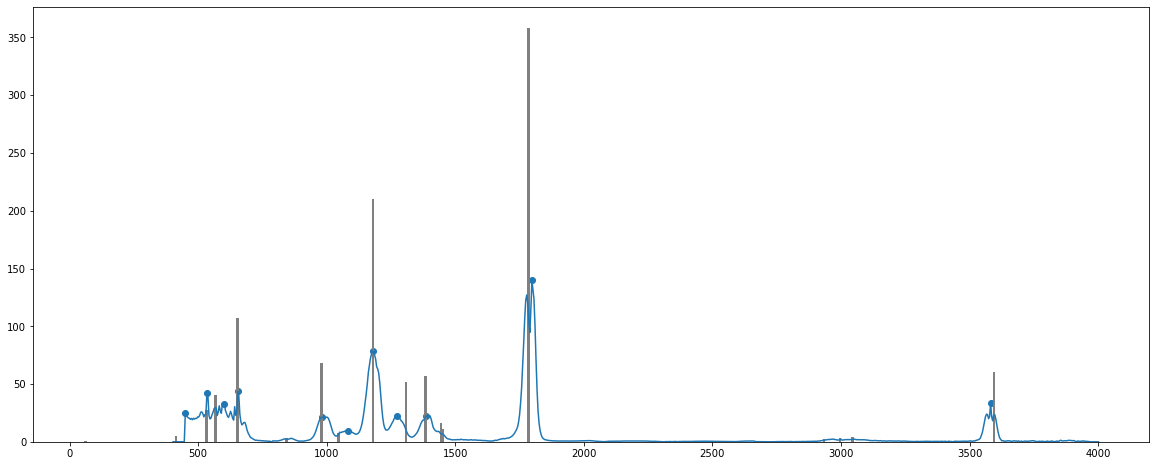

In [542]:
freq_exp, int_exp, _ = find_max(spectrum.x.values, spectrum.y.values, order=10, threshold=spectrum.y.values.mean())
plt.figure(figsize=(20, 8))
plt.plot(spectrum.x, spectrum.y * 100)
plt.scatter(freq_exp, np.array(int_exp) * 100)
structs[struct_name].pm.spectrum_bar()

In [527]:
# norm_int = normalize(np.array(structs[struct_name].intencities).reshape(1, -1), norm='max')[0]
# freqs, intencities, indxs = find_max(np.array(structs[struct_name].freqs), np.array(structs[struct_name].intencities) / 100, order=2, threshold=0.0000001)
# plt.figure(figsize=(20, 8))
# plt.plot(structs[struct_name].freqs, np.array(structs[struct_name].intencities) / 100)
# plt.scatter(freqs, intencities)

indxs = [i for i in range(len(structs[struct_name].intencities)) if structs[struct_name].intencities[i] > 1]
intencities = [structs[struct_name].intencities[i] for i in indxs]
freqs = [structs[struct_name].freqs[i] for i in indxs]

In [528]:
def find_nearest(elem, array):
    ind = 0
    for i in range(len(array)):
        if np.abs(elem - array[i]) < np.abs(elem - array[ind]):
            ind = i
    return ind

In [557]:
table = pd.DataFrame({'freq_theor': freqs, 'int_theor': intencities})
table['freq_exp'] = [freq_exp[find_nearest(freq, freq_exp)] for freq in table.freq_theor]
table['int_exp'] = [int_exp[find_nearest(freq, freq_exp)] for freq in table.freq_theor]
table['ind'] = indxs

In [558]:
table['int_sf'] = table.int_exp / table.int_theor * 100

In [559]:
sums = structs[struct_name].veda_matrix.drop('freq', axis=1).sum()
table['ped_sum'] = [sums[i] for i in table.ind]
table['freq_delta'] = abs(table.freq_theor -  table.freq_exp)

In [560]:
table

,freq_theor,int_theor,freq_exp,int_exp,ind,int_sf,ped_sum,freq_delta
0,3595.151888,60.4457,3582.0,0.331920,0,0.549121,100.0,13.151888
1,3045.757472,4.2280,3582.0,0.331920,1,7.850523,-100.0,536.242528
2,2996.116282,3.6719,3582.0,0.331920,2,9.039465,0.0,585.883718
3,2933.712950,2.0514,3582.0,0.331920,3,16.180175,67.0,648.287050
4,1783.695146,358.5057,1798.0,1.396970,4,0.389665,81.0,14.304854
5,1450.834902,11.1521,1386.0,0.226728,5,2.033054,14.0,64.834902
6,1444.433555,16.4776,1386.0,0.226728,6,1.375978,50.0,58.433555
7,1384.345073,57.3679,1386.0,0.226728,7,0.395218,90.0,1.654927
8,1307.479971,52.0862,1274.0,0.219743,8,0.421884,-50.0,33.479971
9,1179.521552,210.0930,1178.0,0.786354,9,0.374289,91.0,1.521552


In [ ]:
def get


In [534]:
X = structs[struct_name].veda_matrix[:]
X['int_theor'] = structs[struct_name].intencities
# X.drop(['freq', 19], axis=1, inplace=True)

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [545]:
X = X[X.int_theor > 1]
X = X[abs(table.freq_theor  - table.freq_exp) < 60]
labels = table[abs(table.freq_theor  - table.freq_exp) < 60].int_sf
X

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,freq,int_theor
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3755.12,60.4457
4,0.0,0.0,0.0,0.0,85.0,0.0,-5.0,5.0,0.0,1.0,0.0,-1.0,3.0,0.0,0.0,0.0,0.0,0.0,1822.33,358.5057
6,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-17.0,44.0,-17.0,0.0,0.0,0.0,-10.0,10.0,0.0,0.0,1475.72,16.4776
7,0.0,0.0,0.0,0.0,1.0,-6.0,11.0,-4.0,20.0,32.0,20.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1414.33,57.3679
8,0.0,0.0,0.0,0.0,-3.0,22.0,-8.0,33.0,4.0,4.0,4.0,-15.0,0.0,0.0,-3.0,3.0,0.0,0.0,1335.80,52.0862
9,0.0,0.0,0.0,0.0,-6.0,-20.0,4.0,44.0,1.0,-5.0,1.0,0.0,4.0,0.0,7.0,-7.0,0.0,0.0,1205.07,210.0930
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,12.0,0.0,0.0,0.0,-14.0,-14.0,24.0,24.0,1067.37,7.4882
11,0.0,0.0,0.0,0.0,1.0,-17.0,3.0,4.0,-4.0,14.0,-4.0,1.0,-4.0,0.0,-23.0,23.0,0.0,0.0,1001.92,68.6314
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,53.0,2.0,2.0,12.0,-33.0,667.03,106.8064
14,0.0,0.0,0.0,0.0,0.0,4.0,-12.0,5.0,0.0,0.0,0.0,74.0,-4.0,0.0,0.0,0.0,0.0,0.0,580.34,40.2467


In [546]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X, labels)
labels

0     0.549121
4     0.389665
6     1.375978
7     0.395218
8     0.421884
9     0.374289
10    1.268582
11    0.311019
13    0.409649
14    0.809094
15    1.502437
16    5.217391
Name: int_sf, dtype: float64

In [547]:
prediction = lr_model.predict(X)

In [548]:
mean_squared_error(prediction, labels)

5.827170676935796e-29

In [549]:
coefs = lr_model.coef_

<BarContainer object of 20 artists>

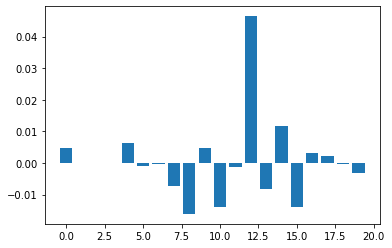

In [550]:
plt.bar(range(len(coefs)), coefs)

In [551]:
def generate_column_sum_veda_matrix(structure):
    columns_sum = dict()
    for column in structure.veda_matrix.columns[:-1]:
        coord_name = structure.internal_coordinates[column].coordinates[0].name
        if coord_name not in columns_sum.keys():
            columns_sum[coord_name] = np.zeros((structure.veda_matrix[column].shape[0],))
            columns_sum[coord_name + '_abs'] = np.zeros((structure.veda_matrix[column].shape[0],))

        columns_sum[coord_name] += structure.veda_matrix[column]
        columns_sum[coord_name + '_abs'] += abs(structure.veda_matrix[column])

    X_name_sum = pd.DataFrame(columns_sum)[np.array(structs[struct_name].intencities) > 1]
    return X_name_sum

In [552]:
X_name_sum = generate_column_sum_veda_matrix(structs[struct_name])
lr_model = LinearRegression()
lr_model.fit(X_name_sum, labels)
prediction = lr_model.predict(X_name_sum)
print(mean_squared_error(prediction, labels))
coefs = lr_model.coef_
plt.bar(range(len(coefs)), coefs)

ValueError: Found input variables with inconsistent numbers of samples: [17, 12]

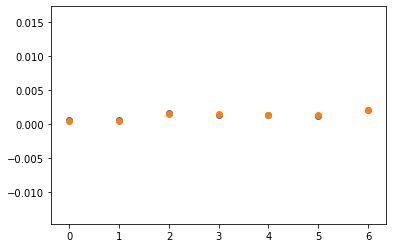

In [516]:
plt.scatter(range(len(prediction - labels)), (prediction))
plt.scatter(range(len(labels)), labels)

In [518]:
labels, prediction

(0    0.000527
 1    0.000527
 2    0.001536
 3    0.001529
 4    0.001269
 5    0.001269
 6    0.002115
 Name: int_sf, dtype: float64,
 array([0.00054367, 0.00054367, 0.00164265, 0.00141078, 0.00126881,
        0.00124802, 0.00211491]))